# 📡 Data Collection

Phần này đảm nhận việc kết nối với các kênh ThingSpeak, thu thập dữ liệu cảm biến theo thời gian thực, 
và lưu trữ tạm thời vào file **data raw (01_data_raw.csv)**.

Các bước chính:
1. Định nghĩa danh sách channel và tọa độ (x, y) trên lưới 5x5.
2. Lấy dữ liệu từ từng channel (sử dụng `requests`).
3. Lấy dữ liệu song song từ tất cả các channel (`ThreadPoolExecutor`).
4. Gộp dữ liệu mới vào file CSV gốc.
5. Lưu dữ liệu thô vào **01_data_raw.csv**.


In [1]:
# ==== Cell 1: Import & cấu hình ====
import pandas as pd
import requests
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from datetime import timedelta

# Danh sách channel ThingSpeak
CHANNELS = [
    '2999637','2999638','2999639','3026849','2999643',
    '2999644','2999645','2999649','2999651','2999652',
    '2982770','3026384','3026386','3026415','3026416',
    '2999925','3025936','2999930','2999931','2999956',
    '2999958','2999959','2999960','3025940','2999996'
]

# Ánh xạ channel → tọa độ (x, y) trên lưới 5x5
COORDS = {cid: {'x': i % 5, 'y': i // 5} for i, cid in enumerate(CHANNELS)}

# File CSV lưu dữ liệu
CSV_FILE = "01_data_raw.csv"

In [8]:
# ==== Cell 2: Hàm lấy dữ liệu ====

def safe_float(v):
    """Chuyển sang float và làm tròn 2 chữ số, lỗi trả None."""
    try:
        return round(float(v), 2)
    except:
        return None

def fetch_channel(cid, start_time=None):
    """
    Lấy dữ liệu từ 1 channel trên ThingSpeak.
    start_time: datetime tz-aware, lấy dữ liệu sau thời điểm này
    Trả về: list of dict với keys ['time','x','y','dust','temp','humidity','MQ2','MQ7']
    """
    url = f"https://api.thingspeak.com/channels/{cid}/feeds.json"
    params = {'results': 8000}  # số lượng bản ghi tối đa/lần
    if start_time:
        # Chuyển start_time sang UTC để ThingSpeak hiểu
        params['start'] = start_time.tz_convert('UTC').strftime("%Y-%m-%dT%H:%M:%SZ")
    
    try:
        r = requests.get(url, params=params, timeout=30).json()
        feeds = r.get('feeds', [])
        if not feeds:
            return []

        data_list = []
        for f in feeds:
            # Chỉ lấy các bản ghi có ít nhất 1 field hợp lệ
            if any(safe_float(f.get(k)) is not None for k in ['field8','field1','field2','field5','field3']):
                data_list.append({
                    'time': pd.to_datetime(f['created_at']).tz_convert("Asia/Bangkok"),
                    'x': COORDS[cid]['x'],
                    'y': COORDS[cid]['y'],
                    'dust': safe_float(f.get('field8')),
                    'temp': safe_float(f.get('field1')),
                    'humidity': safe_float(f.get('field2')),
                    'MQ2': safe_float(f.get('field5')),
                    'MQ7': safe_float(f.get('field3'))
                })
        return data_list

    except Exception as e:
        print(f"❌ Lỗi channel {cid}: {e}")
        return []


In [3]:
# ==== Cell 4: Lấy dữ liệu song song từ tất cả channel ====

def fetch_all_channels(start_time=None):
    """
    Lấy dữ liệu từ tất cả các channel song song.
    start_time: datetime tz-aware, lấy dữ liệu sau thời điểm này
    Trả về: list of dict chứa dữ liệu tất cả channel
    """
    results = []
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = {executor.submit(fetch_channel, cid, start_time): cid for cid in CHANNELS}
        
        for future in tqdm(as_completed(futures), total=len(futures), desc="📡 Đang lấy dữ liệu"):
            cid = futures[future]
            try:
                data = future.result()
                if data:
                    results.extend(data)
            except Exception as e:
                print(f"❌ Channel {cid} lỗi: {e}")
    return results


In [4]:
# ==== Cell 5: Thu thập & lưu dữ liệu tới hiện tại ====
import os
from datetime import datetime, timezone, timedelta
import pandas as pd

def collect_all():
    """
    Thu thập dữ liệu mới từ tất cả channel và lưu vào CSV.
    Ghi log rõ ràng: từ thời điểm nào → tới hiện tại
    """
    if os.path.exists(CSV_FILE):
        df_old = pd.read_csv(CSV_FILE, parse_dates=['time'])
        # Chuyển sang tz-aware Asia/Bangkok
        try:
            df_old['time'] = df_old['time'].dt.tz_convert('Asia/Bangkok')
        except TypeError:
            df_old['time'] = df_old['time'].dt.tz_localize('Asia/Bangkok')

        last_time = df_old['time'].max()
        print(f"🕒 Bắt đầu lấy dữ liệu từ: {last_time}")
    else:
        df_old = pd.DataFrame()
        last_time = None
        print("📂 Chưa có dữ liệu cũ → Lấy toàn bộ")

    # Lấy dữ liệu mới từ API
    new_data = fetch_all_channels(start_time=last_time)

    if not new_data:
        print("⚠ Không có dữ liệu mới")
        return

    # Chuyển sang DataFrame
    df_new = pd.DataFrame(new_data)

    # Gộp với dữ liệu cũ và loại bỏ trùng
    df = pd.concat([df_old, df_new]).drop_duplicates(subset=['time','x','y'])

    # Sắp xếp theo time -> x -> y
    df.sort_values(['time','x','y'], inplace=True)

    # Lưu file
    df.to_csv(CSV_FILE, index=False, encoding='utf-8-sig')

    # Log thông tin
    latest_api_time = df_new['time'].max()
    now_bkk = pd.Timestamp.now(tz='Asia/Bangkok')
    delay_min = (now_bkk - latest_api_time).total_seconds() / 60
    print(f"💾 Lưu {len(df_new)} bản ghi mới → Tổng {len(df)} dòng")
    print(f"🕒 Dữ liệu mới nhất từ API: {latest_api_time}")
    print(f"🕒 Thời điểm hiện tại:      {now_bkk}")
    print(f"⏳ Độ trễ dữ liệu: {delay_min:.2f} phút")


In [5]:
# ==== Cell 5: Chạy ====
collect_all()


📂 Chưa có dữ liệu cũ → Lấy toàn bộ


📡 Đang lấy dữ liệu: 100%|██████████| 25/25 [03:12<00:00,  7.68s/it]


💾 Lưu 200000 bản ghi mới → Tổng 200000 dòng
🕒 Dữ liệu mới nhất từ API: 2025-08-19 15:34:19+07:00
🕒 Thời điểm hiện tại:      2025-08-25 01:34:29.205411+07:00
⏳ Độ trễ dữ liệu: 7800.17 phút


In [6]:
collect_all()

🕒 Bắt đầu lấy dữ liệu từ: 2025-08-19 15:34:19+07:00


📡 Đang lấy dữ liệu: 100%|██████████| 25/25 [00:02<00:00,  9.54it/s]


💾 Lưu 1 bản ghi mới → Tổng 200000 dòng
🕒 Dữ liệu mới nhất từ API: 2025-08-19 15:34:19+07:00
🕒 Thời điểm hiện tại:      2025-08-25 01:34:39.624907+07:00
⏳ Độ trễ dữ liệu: 7800.34 phút


# 🧹 Data Cleaning

Phần này xử lý dữ liệu gốc thu thập được để chuẩn hóa trước khi dùng cho AI:

1. Đọc file **01_data_raw.csv**.
2. Tạo khung dữ liệu đầy đủ: tất cả thời điểm cách nhau 20 giây và đủ 25 sensor (5x5).
3. Nội suy các giá trị thiếu theo thời gian cho từng sensor.
4. Điền giá trị trung bình nếu sensor chưa từng có dữ liệu.
5. Sắp xếp dữ liệu theo `time -> x -> y`.
6. Lưu kết quả vào **02_data_clean.csv**.
7. Kiểm tra dữ liệu bằng heatmap ngẫu nhiên.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# === 1. Đọc dữ liệu gốc ===
file_path = "01_data_raw.csv"
print("📂 Đang đọc dữ liệu gốc từ:", file_path)
df = pd.read_csv(file_path)

# Chuyển time sang datetime
df['time'] = pd.to_datetime(df['time'])

# Xem 25 dòng đầu
print("\n📌 25 dòng đầu tiên của dữ liệu gốc:")
print(df.head(25))


📂 Đang đọc dữ liệu gốc từ: 01_data_raw.csv

📌 25 dòng đầu tiên của dữ liệu gốc:
                        time  x  y  dust  temp  humidity    MQ2    MQ7
0  2025-08-09 14:09:27+07:00  1  4   0.0  24.3      57.0  671.0  378.7
1  2025-08-09 14:09:57+07:00  1  4   0.0  24.3      57.0  654.0  377.5
2  2025-08-09 14:10:12+07:00  1  4   0.0  24.3      57.0  657.0  383.4
3  2025-08-09 14:10:42+07:00  1  4   0.0  24.3      57.0  658.0  378.7
4  2025-08-09 14:10:57+07:00  1  4   0.0  24.2      57.0  709.0  379.5
5  2025-08-09 14:11:12+07:00  1  4   0.0  24.3      57.0  656.0  377.7
6  2025-08-09 14:11:42+07:00  1  4   0.0  24.3      58.0  662.0  382.7
7  2025-08-09 14:12:12+07:00  1  4   0.0  24.2      57.0  653.0  379.6
8  2025-08-09 14:12:27+07:00  1  4   0.0  24.3      57.0  706.0  382.5
9  2025-08-09 14:12:58+07:00  1  4   0.0  24.3      57.0  709.0  382.8
10 2025-08-09 14:13:13+07:00  1  4   0.0  24.3      57.0  660.0  379.2
11 2025-08-09 14:13:43+07:00  1  4   0.0  24.3      57.0  657.0  372

In [9]:
# === 2. Tạo khung dữ liệu đầy đủ ===

# Danh sách thời gian cách nhau 20s
time_range = pd.date_range(start=df['time'].min(), end=df['time'].max(), freq='20s')
print(f"✅ Tổng số mốc thời gian (20s): {len(time_range)}")

# Danh sách tọa độ sensor 5x5
coords = [(x, y) for y in range(1, 6) for x in range(1, 6)]

# MultiIndex time × coords
full_index = pd.MultiIndex.from_product([time_range, coords], names=['time', 'coord'])
df_full = pd.DataFrame(index=full_index).reset_index()

# Tách x,y
df_full[['x', 'y']] = pd.DataFrame(df_full['coord'].tolist(), index=df_full.index)
df_full.drop(columns=['coord'], inplace=True)

# Gộp dữ liệu gốc
df_full = df_full.merge(df, on=['time', 'x', 'y'], how='left')


✅ Tổng số mốc thời gian (20s): 43455


In [10]:
# === 3. Điền giá trị thiếu ===
print("🔄 Nội suy dữ liệu theo thời gian cho từng sensor...")

df_interp = (
    df_full.groupby(['x', 'y'], group_keys=False)
           .apply(lambda g: g.set_index('time').interpolate(method='time').reset_index())
           .reset_index(drop=True)
)

# Lấy cột cần giữ
cols_keep = ['time', 'x', 'y', 'dust', 'temp', 'humidity', 'MQ2', 'MQ7']
df_full = df_interp[cols_keep]

# Điền trung bình cho sensor chưa bao giờ có dữ liệu
for col in ['dust', 'temp', 'humidity', 'MQ2', 'MQ7']:
    mean_val = df_full[col].mean()
    df_full[col] = df_full[col].fillna(mean_val)

print("✅ Hoàn tất xử lý giá trị thiếu")
print("\n📌 Kiểm tra NaN sau xử lý:")
print(df_full.isna().sum())


🔄 Nội suy dữ liệu theo thời gian cho từng sensor...
✅ Hoàn tất xử lý giá trị thiếu

📌 Kiểm tra NaN sau xử lý:
time        0
x           0
y           0
dust        0
temp        0
humidity    0
MQ2         0
MQ7         0
dtype: int64


C:\Users\nhat\AppData\Local\Temp\ipykernel_4156\2471832269.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.set_index('time').interpolate(method='time').reset_index())


In [11]:
# === 4. Lưu dữ liệu sạch ===
# Sắp xếp theo time -> x -> y
df_full = df_full.sort_values(['time', 'x', 'y']).reset_index(drop=True)

output_path = "02_data_clean.csv"
df_full.to_csv(output_path, index=False)
print(f"💾 File dữ liệu sạch đã lưu: {output_path}")


💾 File dữ liệu sạch đã lưu: 02_data_clean.csv


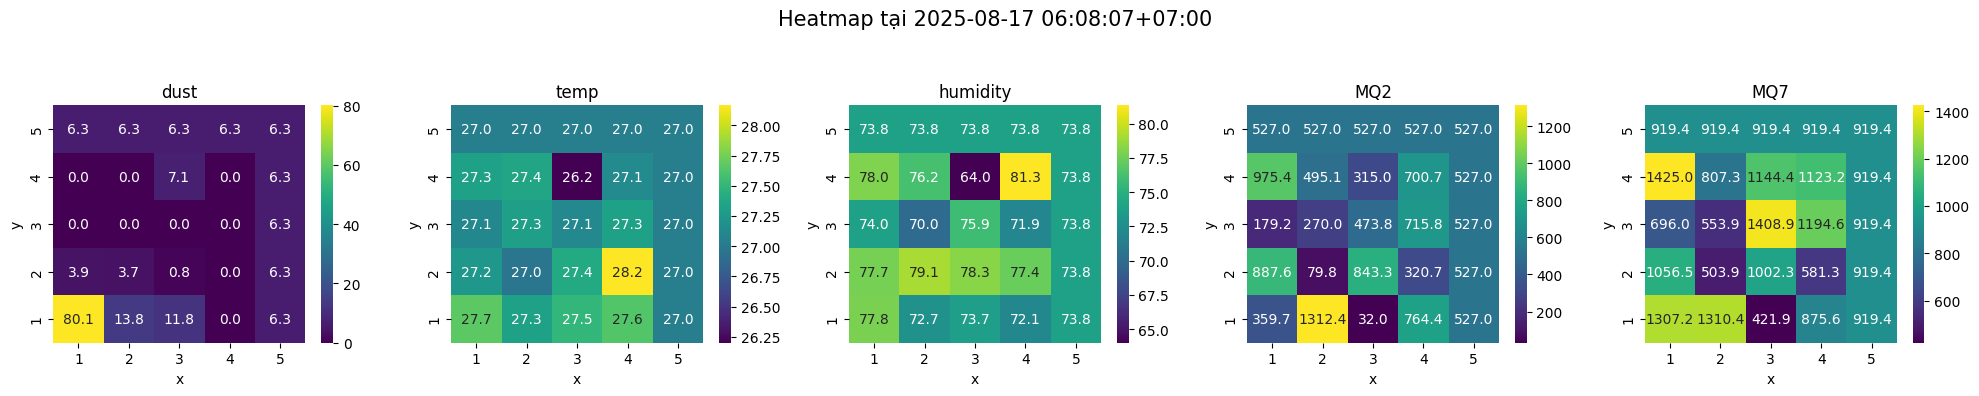

In [12]:
# === 5. Đọc file sạch & kiểm tra heatmap ===
import random
import seaborn as sns
import matplotlib.pyplot as plt

# Danh sách thông số cần vẽ
FEATURES = ["dust", "temp", "humidity", "MQ2", "MQ7"]

# Đọc file
df_clean = pd.read_csv(output_path)
df_clean['time'] = pd.to_datetime(df_clean['time'])

# Chọn ngẫu nhiên 1 thời điểm
sample_time = random.choice(df_clean['time'].unique())
df_sample = df_clean[df_clean['time'] == sample_time]

# Pivot một lần cho nhanh
pivoted = {
    param: df_sample.pivot(index='y', columns='x', values=param).sort_index(ascending=False) 
    for param in FEATURES
}

# Vẽ figure gồm 5 heatmap
fig, axes = plt.subplots(1, len(FEATURES), figsize=(20, 4))
fig.suptitle(f"Heatmap tại {sample_time}", fontsize=15)

for fi, fname in enumerate(FEATURES):
    sns.heatmap(pivoted[fname], annot=True, fmt=".1f", cmap="viridis", ax=axes[fi])
    axes[fi].set_title(fname)
    axes[fi].set_xlabel("x")
    axes[fi].set_ylabel("y")

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()
